<a href="https://colab.research.google.com/github/furkanoruc/final-project-GSU/blob/main/Metastasis_Classification_GradCam_Visuals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#torch

from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import torchvision.transforms as trans
import time
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

#libs
import numpy as np 
import seaborn as sns
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
import sys
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from PIL import Image
Image.MAX_IMAGE_PIXELS = None

from torch.utils import data
from torchvision.models import vgg19

import cv2
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
import torchvision
import torchvision.transforms as trans
import numpy as np
import matplotlib.pyplot as plt



PyTorch Version:  1.12.1+cu113
Torchvision Version:  0.13.1+cu113


Reference: https://leslietj.github.io/2020/07/15/PyTorch-Implementation-of-Class-Activation-Map-CAM/

https://github.com/LeslieTj/pytorch_notes_for_cnn

In [ ]:
#Yes - All
!wget -O data1.zip https://www.dropbox.com/sh/neoa6gp229lsyze/AACYeCrQRGulJUqbqmoIlxKDa?dl=0


--2022-11-25 15:01:55--  https://www.dropbox.com/sh/neoa6gp229lsyze/AACYeCrQRGulJUqbqmoIlxKDa?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /sh/raw/neoa6gp229lsyze/AACYeCrQRGulJUqbqmoIlxKDa [following]
--2022-11-25 15:01:55--  https://www.dropbox.com/sh/raw/neoa6gp229lsyze/AACYeCrQRGulJUqbqmoIlxKDa
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc6493ceba4cd70a84fe943f38fa.dl.dropboxusercontent.com/zip_download_get/BU3SHGwcMiYy8k0nGF4A-IXXqKHnFcrSFYvR509zW95RJ1tvAjxM9s1eaeROg7Fl_ZSFNMm2XEN9yB2Vic5j3_VkHmfymUKPr1lJ05RAgmCd0g# [following]
--2022-11-25 15:01:56--  https://uc6493ceba4cd70a84fe943f38fa.dl.dropboxusercontent.com/zip_download_get/BU3SHGwcMiYy8k0nGF4A-IXXqKHnFcrSFYvR509zW95RJ1tvAjxM9s1eaeROg7Fl_ZSFNMm2XEN9yB2Vic5j3_VkHmfy

In [ ]:
!unzip data1.zip -x / -d data/Yes-All

Archive:  data1.zip
 extracting: data/Yes-All/SUS13___2021_07_15_18.45.27  
 extracting: data/Yes-All/SUS35___2021_06_17_12.01.28  
 extracting: data/Yes-All/SUS52___2021_07_15_22.02.37  
 extracting: data/Yes-All/SUS62___2021_07_15_23.08.59  
 extracting: data/Yes-All/SUS64___2021_07_15_23.32.13  
 extracting: data/Yes-All/SUS99___2021_07_16_02.31.18  
 extracting: data/Yes-All/SUS19___2021_07_15_19.33.44  
 extracting: data/Yes-All/SUS25___2021_07_15_20.19.20  
 extracting: data/Yes-All/SUS43___2021_07_15_21.16.08  
 extracting: data/Yes-All/SUS54___2021_07_15_22.19.37  
 extracting: data/Yes-All/SUS68___2021_07_15_23.59.25  
 extracting: data/Yes-All/SUS70___2021_07_16_00.07.57  
 extracting: data/Yes-All/SUS74___2021_07_16_00.44.36  
 extracting: data/Yes-All/SUS79___2021_07_16_01.14.39  
 extracting: data/Yes-All/SUS92___2021_07_16_01.52.18  
 extracting: data/Yes-All/SUS57 - 2021-07-15 22.38.45  
 extracting: data/Yes-All/SUS108___2021_07_16_03.00.38  
 extracting: data/Yes-All/S

In [ ]:
#No - Met
!wget -O data2.zip https://www.dropbox.com/sh/9roj2avzwmw7tmm/AAAC5SkTW9oZtdUEUbk7_iPHa?dl=0


--2022-11-25 15:03:10--  https://www.dropbox.com/sh/9roj2avzwmw7tmm/AAAC5SkTW9oZtdUEUbk7_iPHa?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.66.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.66.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /sh/raw/9roj2avzwmw7tmm/AAAC5SkTW9oZtdUEUbk7_iPHa [following]
--2022-11-25 15:03:10--  https://www.dropbox.com/sh/raw/9roj2avzwmw7tmm/AAAC5SkTW9oZtdUEUbk7_iPHa
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc197bf812ac79c7ba48e5a4caaa.dl.dropboxusercontent.com/zip_download_get/BU1zNWZoRgcH3ZJpf3hAoKgEuQ4q07FEDPOucye_0H1qJqVmVR-SDd0fNYe9ZWj_pCi30f5SwmB4YLZ9XHmqXo5_DuCKN0bJDFU8PElBvqRR8w# [following]
--2022-11-25 15:03:12--  https://uc197bf812ac79c7ba48e5a4caaa.dl.dropboxusercontent.com/zip_download_get/BU1zNWZoRgcH3ZJpf3hAoKgEuQ4q07FEDPOucye_0H1qJqVmVR-SDd0fNYe9ZWj_pCi30f5SwmB4YLZ9XHmqXo5_Du

In [ ]:
!unzip data2.zip -x / -d data/No-Met-All

Archive:  data2.zip
 extracting: data/No-Met-All/SUS20___2021_07_15_19.46.27  
 extracting: data/No-Met-All/SUS23___2021_07_15_19.54.29  
 extracting: data/No-Met-All/SUS24___2021_07_15_20.10.33  
 extracting: data/No-Met-All/SUS48___2021_07_15_21.41.06  
 extracting: data/No-Met-All/SUS51___2021_07_15_21.52.24  
 extracting: data/No-Met-All/SUS65___2021_06_17_12.12.01  
 extracting: data/No-Met-All/SUS66___2021_07_15_23.40.57  
 extracting: data/No-Met-All/SUS67___2021_07_15_23.51.11  
 extracting: data/No-Met-All/SUS53___2021_07_15_22.15.00  
 extracting: data/No-Met-All/SUS56___2021_07_15_22.25.32  
 extracting: data/No-Met-All/SUS11___2021_07_15_18.26.59  
 extracting: data/No-Met-All/SUS15___2021_07_15_18.58.21  
 extracting: data/No-Met-All/SUS16___2021_07_15_19.06.32  
 extracting: data/No-Met-All/SUS17___2021_07_15_19.14.11  
 extracting: data/No-Met-All/SUS18___2021_07_15_19.22.45  
 extracting: data/No-Met-All/SUS26___2021_07_15_20.24.21  
 extracting: data/No-Met-All/SUS27__

# Grad-CAM

In [ ]:
img = plt.imread('data/Yes-All/SUS108___2021_07_16_03')
plt.imshow(img)

FileNotFoundError: ignored

In [ ]:
img = plt.imread('data/No-Met-All/SUS143___2021_07_16_06.32.15')
plt.imshow(img)

In [ ]:
!rm data1.zip
!rm data2.zip

In [ ]:
#!rm -rf output
#/content/data/No-Met-All/SUS143___2021_07_16_06.32.15.tiff

In [ ]:
!find data/No-Met-All -type f -exec mv '{}' '{}'.tiff \;
!find data/Yes-All -type f -exec mv '{}' '{}'.tiff \;

In [ ]:
torch.use_deterministic_algorithms(False)

In [ ]:
!pip install split-folders
import splitfolders
splitfolders.ratio('data', output="output", seed=1915, ratio=(0.8,0.2))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 70 files [01:14,  1.06s/ files]


In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation

data_dir = './output/'
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
root_dir = './output/'

In [ ]:
classes = os.listdir('./output2/val')
print(classes)

['No-Met-All', 'Yes-All']


In [ ]:
data_transforms = {
    'train': trans.Compose([
        trans.Resize(224),
        #trans.CenterCrop(100),
        trans.RandomHorizontalFlip(),
        #trans.FiveCrop(50),
        trans.ToTensor(),
        # when do the transform, image pixels are compressed 
        # from (0,255) to (0,1) then we do the normalization
        trans.Normalize([0.485, 0.456, 0.406], # mean of RGB
                        [0.229, 0.224, 0.225]) # std of RGB
    ]), 
    'val': trans.Compose([
        trans.Resize(256),
        #trans.CenterCrop(100),
        #trans.FiveCrop(50),
        trans.ToTensor(),
        trans.Normalize([0.485, 0.456, 0.406], 
                        [0.229, 0.224, 0.225])
    ])    
}


train_data = torchvision.datasets.ImageFolder(
    root=os.path.join(root_dir, 'train'),
    transform=data_transforms['train']
)


val_data = torchvision.datasets.ImageFolder(
    root=os.path.join(root_dir, 'val'),
    transform=data_transforms['val']
)


class_names = train_data.classes
dataset_sizes = {'train': len(train_data), 'val': len(val_data)}

dataloaders = {  
    'train': Data.DataLoader(
        dataset=train_data,
        batch_size=1,
        shuffle=True,
#         num_workers=4
    ),

    'val': Data.DataLoader(
        dataset=val_data,
        batch_size=1,
        shuffle=True,
#         num_workers=4
    ),    
}

# denormalize and show an image 
def imshow(image, title=None):
    image = image.numpy().transpose((1, 2, 0)) 
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = image * std + mean
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    if title:
        plt.title(title)

# get a batch of training data
#images, classes = next(iter(dataloaders['train']))

# make a grid from batch
#images = torchvision.utils.make_grid(images)

#imshow(images, title=[class_names[x] for x in classes])

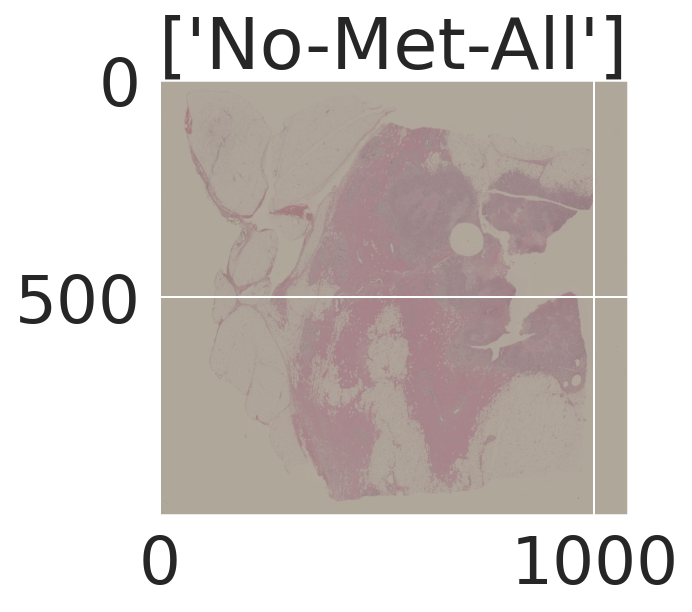

In [ ]:
tf=transforms.Compose([
    trans.Resize((1000)),
    trans.ToTensor()
])

train_data_visualize = torchvision.datasets.ImageFolder(
    root=os.path.join(root_dir, 'train'),
    transform=tf
)

dataloaders_visualize = {  
    'train': Data.DataLoader(
        dataset=train_data_visualize,
        batch_size=1,
        shuffle=True,
#       num_workers=4
    )}

images_visualize, classes_visualize = next(iter(dataloaders_visualize['train']))
images_visualize = torchvision.utils.make_grid(images_visualize)
imshow(images_visualize, title=[class_names[x] for x in classes_visualize])


In [ ]:
vgg = torchvision.models.vgg16(pretrained=True) 
print('VGG16 Architecture:\n', vgg)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG16 Architecture:
 VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, 

In [ ]:
# reconstruct VGG16, i.e. remove the classifier and replace it with GAP
class VGG(torch.nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.vgg = torchvision.models.vgg16(pretrained=True) 
        self.conv = nn.Sequential(
            self.vgg.features, 
            self.vgg.avgpool 
        )
         
        # self.fc = nn.Linear(512, num_of_class)
        # as we use ImageNet, num_of_class=1000
        self.fc = nn.Linear(512, 1000) #(512, 1000)

    
    def forward(self,x):    
        x = self.conv(x) # -> (512, 7, 7)
        
        
        # we use GAP to replace the fc layer, therefore we need to
        # convert (512,7,7) to (512, 7x7)(i.e. each group contains 7x7=49 values), 
        # then convert (512, 7x7) to (512, 1x1) by mean(1)(i.e. average 49 values in each group), 
        # and finally convert (512, 1) to (1, 512) 
        x = x.view(512,7*7).mean(1).view(1,-1) # -> (1, 512)
        
        # FW^T = S
        # where F is the averaged feature maps, which is of shape (1,512)
        # W is the weights for fc layer, which is of shape (1000, 512)
        # S is the scores, which is of shape (1, 1000)
        x = self.fc(x) #x -> # -> (1, 1000)
        return x 

In [ ]:
def train_model(model, loss_fn, optimizer, scheduler, num_epochs=25):
    """
    net: the model to be trained
    loss_fn: loss function
    scheduler: torch.optim.lr_scheduler
    """
    
    best_model_weights = copy.deepcopy(model.state_dict())
    best_accuracy = 0.0
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-'*10)
        
        step_loss = 0.0
        epoch_accuracy = 0.0
        
        # each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() # set to training mode
            else:
                model.eval() # set to evaluate mode
            
            step_loss = 0.0
            step_corrects = 0
            
            for step, (images, labels) in enumerate(dataloaders[phase]):      
               
                # forward pass, compute loss and make predictions
                outputs = model(images) 
                preds = torch.max(outputs, 1)[1]
                loss = loss_fn(outputs, labels)
                
                # backward pass and update weights if in training phase
                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                # compute step loss and step corrects
                step_loss += loss.item() * images.size(0) # loss.item() extracts the loss's value
                step_corrects += torch.sum(preds == labels.data)
            
            
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = step_loss / dataset_sizes[phase]
            epoch_accuracy = step_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Accuracy: {:.4f}'.format(
                phase, epoch_loss, epoch_accuracy))

            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_accuracy)
            else:
                val_loss.append(epoch_loss)
                val_acc.append(epoch_accuracy)

            # deep copy the model
            if phase == 'val' and epoch_accuracy > best_accuracy:
                best_accuracy = epoch_accuracy
                best_model_weights = copy.deepcopy(model.state_dict())
            
        print()
        
    print('Best Validation Accuracy: {:4f}'.format(best_accuracy))

    # draw the loss history and accuracy history
    x = np.arange(num_epochs)
    plt.subplot(221)
    plt.plot(x, train_loss, c='red', label='train loss')
    plt.plot(x, val_loss, c='blue', label='val loss')
    plt.legend(loc='best')

    plt.subplot(222)
    plt.plot(x, train_acc, c='red', label='train acc')
    plt.plot(x, val_acc, c='blue', label='val acc')
    plt.legend(loc='best')

    plt.show()
    
    # load best model weights
    model.load_state_dict(best_model_weights)
    return model

In [ ]:
# generic function to display predictions for a few images
def visualize_model(model, num_images=14):
    sns.set(font_scale=1)
    was_training = model.training # if true, the model is in training mode otherwise in evaluate mode
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    for step, (images, labels) in enumerate(dataloaders['val']): 
        outputs = model(images)
        preds = torch.max(outputs, 1)[1]
        
        
        for i in range(images.size(0)):
            images_so_far += 1
            ax = plt.figure(figsize=(20,20))
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('on')
            ax.set_title('predicted: {}'.format(class_names[preds[i]]))
            #ax.set_xlabel(label)
            imshow(images.cpu().data[i])
            
            if images_so_far == num_images:
                model.train(mode=was_training)
                return
    
    model.train(mode=was_training)

In [ ]:
class_weights = [0.3, 0.7]
class_weights

[0.3, 0.7]

In [ ]:
model = VGG()

trainable_parameters = []
for name, p in model.named_parameters():
    if "fc" in name:
        trainable_parameters.append(p)

#class_weights = [0.3, 0.7]
class_weights = torch.tensor([0.3,0.7],dtype=torch.float)
loss_fn = torch.nn.CrossEntropyLoss() #weight = class_weights
loss_fn = loss_fn.to(device)

# all parameters are being optimized
optimizer = torch.optim.SGD(trainable_parameters, lr=0.01, momentum=0.9) #lr: 0.001->0.01

# decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.2)

Epoch 0/9
----------
train Loss: 1.7624 Accuracy: 0.6727
val Loss: 2.6521 Accuracy: 0.3333

Epoch 1/9
----------
train Loss: 0.9577 Accuracy: 0.5455
val Loss: 0.8871 Accuracy: 0.6000

Epoch 2/9
----------
train Loss: 0.4599 Accuracy: 0.7818
val Loss: 0.8391 Accuracy: 0.5333

Epoch 3/9
----------
train Loss: 0.4422 Accuracy: 0.8000
val Loss: 0.8413 Accuracy: 0.5333

Epoch 4/9
----------
train Loss: 0.4699 Accuracy: 0.8000
val Loss: 0.8407 Accuracy: 0.5333

Epoch 5/9
----------
train Loss: 0.4233 Accuracy: 0.8000
val Loss: 0.8407 Accuracy: 0.5333

Epoch 6/9
----------
train Loss: 0.4627 Accuracy: 0.8000
val Loss: 0.8407 Accuracy: 0.5333

Epoch 7/9
----------
train Loss: 0.4763 Accuracy: 0.7818
val Loss: 0.8407 Accuracy: 0.5333

Epoch 8/9
----------
train Loss: 0.4708 Accuracy: 0.8000
val Loss: 0.8407 Accuracy: 0.5333

Epoch 9/9
----------
train Loss: 0.4683 Accuracy: 0.8000
val Loss: 0.8407 Accuracy: 0.5333

Best Validation Accuracy: 0.600000


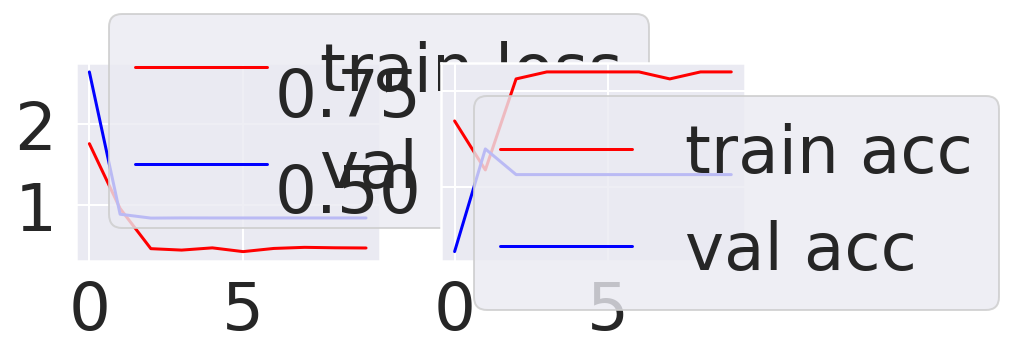

In [ ]:
model = train_model(model, loss_fn, optimizer, exp_lr_scheduler, num_epochs=10)

<Figure size 432x288 with 0 Axes>

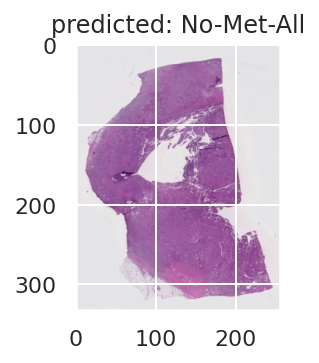

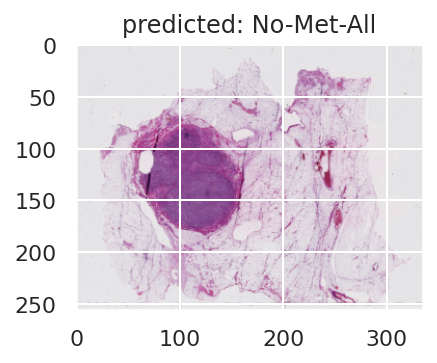

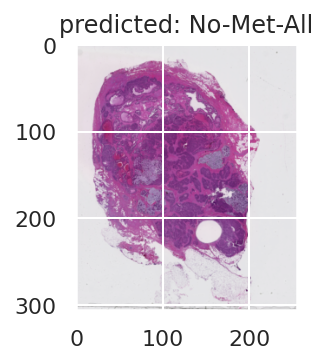

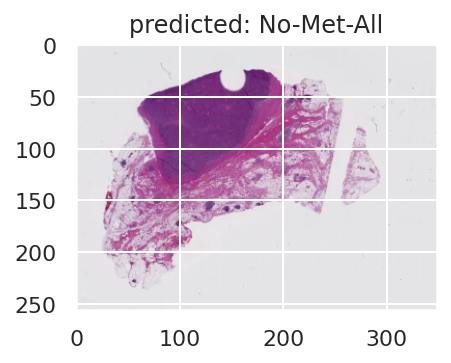

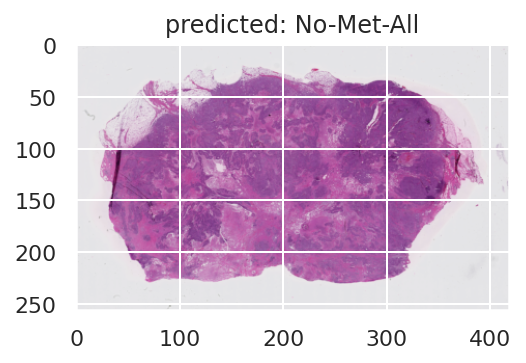

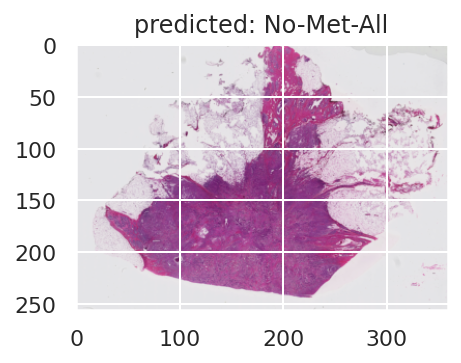

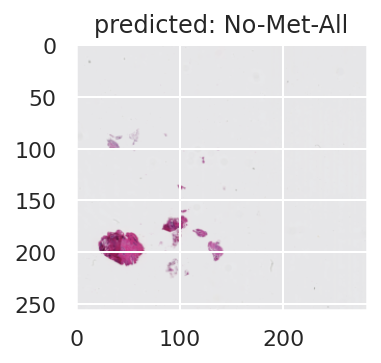

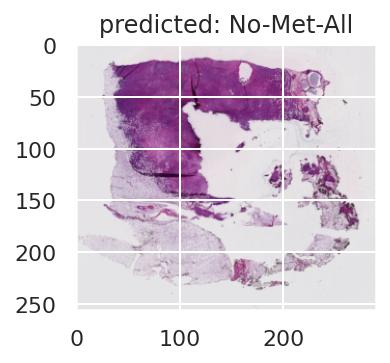

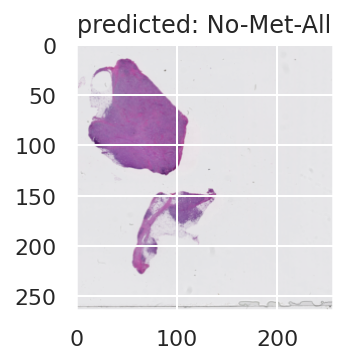

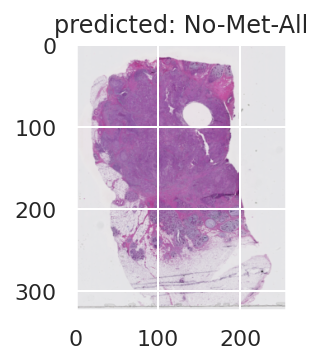

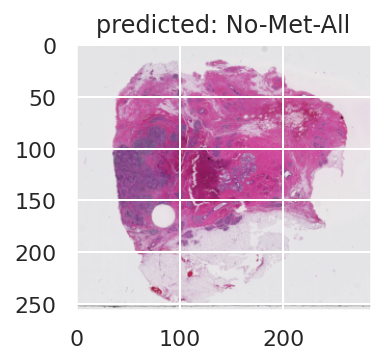

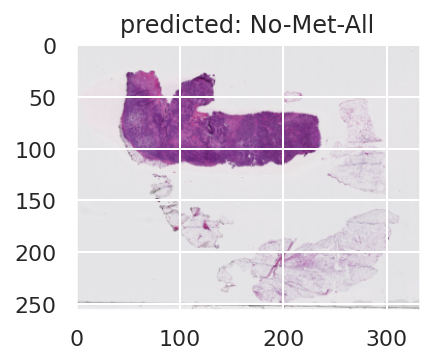

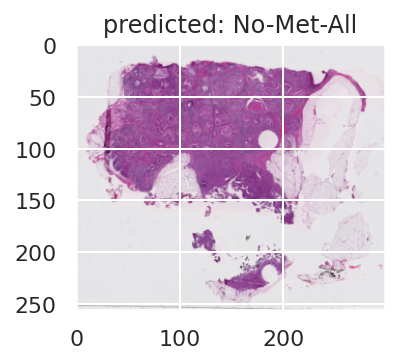

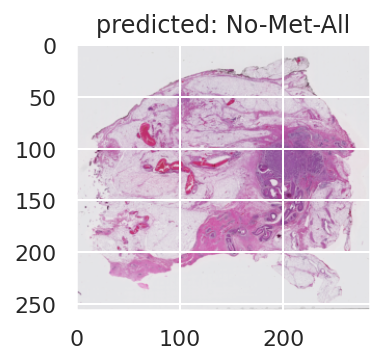

In [ ]:
visualize_model(model)

In [ ]:
params = list(model.fc.parameters())
weight = np.squeeze(params[0].data.numpy())
print('weight.shape', weight.shape)

weight.shape (1000, 512)


In [ ]:
image, label = next(iter(dataloaders['val']))

model.eval()
scores = model(image) # get the raw scores
probs = F.softmax(scores, dim=1).data.squeeze() # use softmax to generate the probability distribution for the scores
probs, idx = probs.sort(0, True) # sort the probability distribution in descending order, and idx[0] is the predicted class
print('sum of probabilities: %.0f'%torch.sum(probs).numpy())
print('true class: ', class_names[label])
print('predicted class: ', class_names[idx[0].numpy()])

sum of probabilities: 1
true class:  Yes-All
predicted class:  No-Met-All


feature_maps.shape:  (1, 512, 7, 7)
original image shape:  (224, 224, 3)
heatmap.shape: (224, 224, 3)


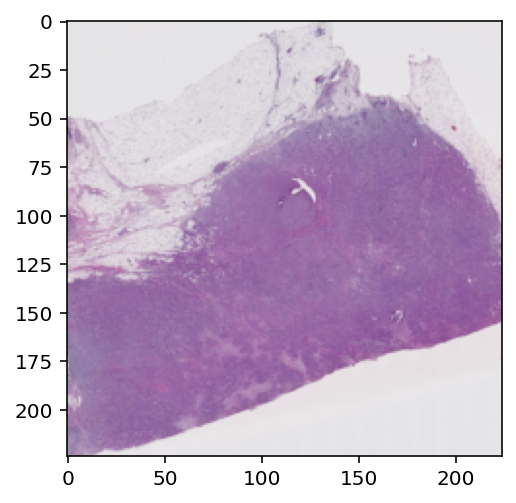

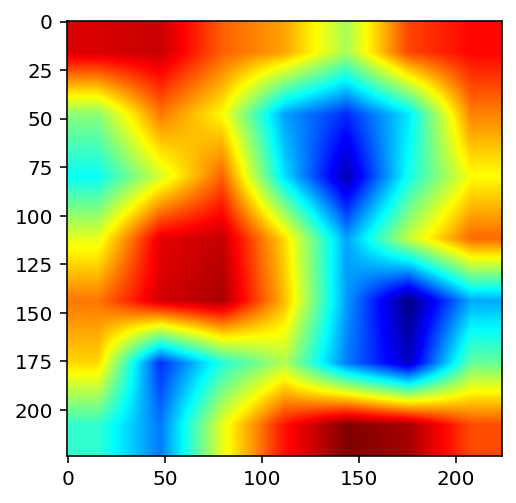

True

In [ ]:
def return_CAM(feature_conv, weight, class_idx):
    """
    return_CAM generates the CAMs and up-sample it to 224x224
    arguments:
    feature_conv: the feature maps of the last convolutional layer
    weight: the weights that have been extracted from the trained parameters
    class_idx: the label of the class which has the highest probability
    """
    size_upsample = (224, 224)
    
    # we only consider one input image at a time, therefore in the case of 
    # VGG16, the shape is (1, 512, 7, 7)
    bz, nc, h, w = feature_conv.shape 
    output_cam = []
    for idx in class_idx:
        beforeDot =  feature_conv.reshape((nc, h*w))# -> (512, 49)
        cam = np.matmul(weight[idx], beforeDot) # -> (1, 512) x (512, 49) = (1, 49)
        cam = cam.reshape(h, w) # -> (7 ,7)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam


feature_maps = model.conv(image) # get the feature maps of the last convolutional layer
print('feature_maps.shape: ', feature_maps.detach().numpy().shape)

CAMs = return_CAM(feature_maps.detach().numpy(), weight, [idx.numpy()[0]]) # generate the CAM for the input image
heatmap = cv2.applyColorMap(CAMs[0], cv2.COLORMAP_JET)


print('original image shape: ', image.reshape((3, 224, 224)).numpy().transpose((1,2,0)).shape)
print('heatmap.shape:', heatmap.shape)
image = image.reshape((3, 224, 224)).numpy().transpose((1, 2, 0)) 
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
image = image * std + mean
image = np.clip(image, 0, 1)

plt.imshow(image)
plt.show()
plt.imshow(heatmap)
plt.show()

result = 0.5 * heatmap + 0.5 * image
cv2.imwrite('cam.png', result)

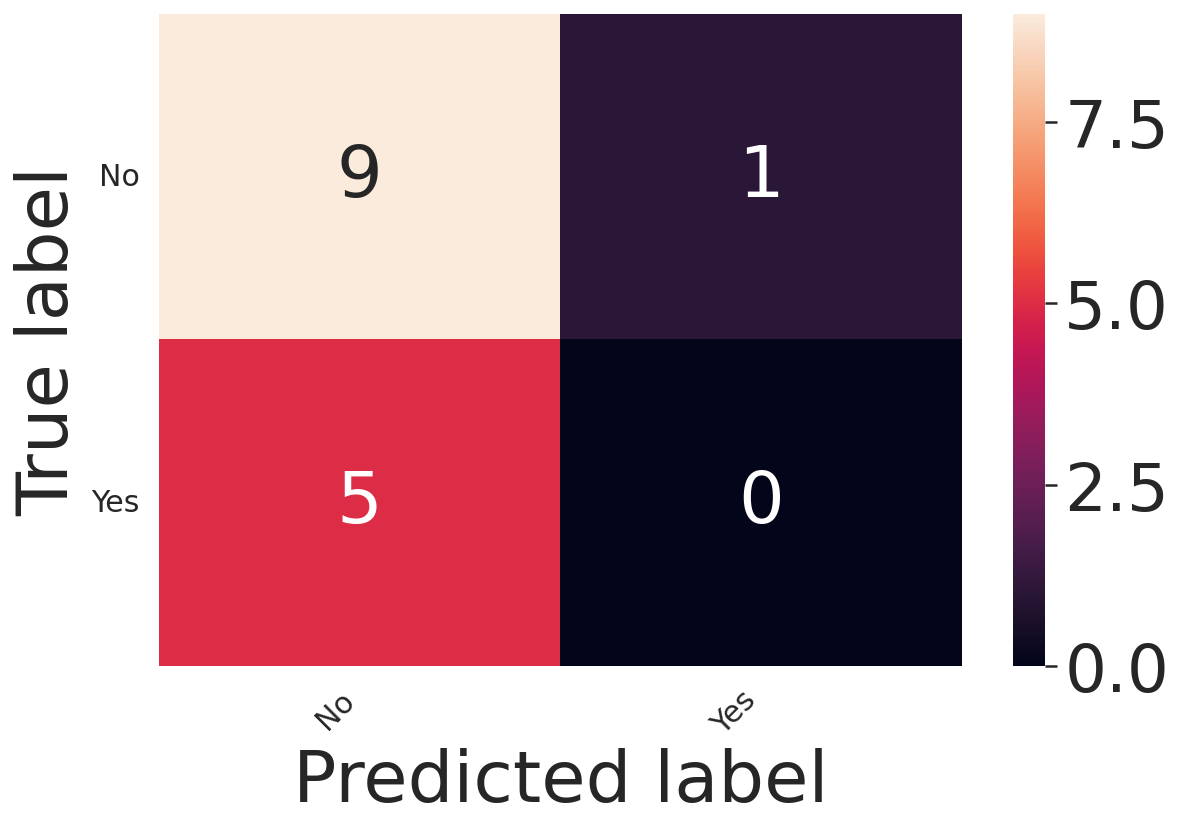

In [ ]:
nb_classes = 2
confusion_matrix = np.zeros((nb_classes, nb_classes))
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

sns.set(font_scale=3) # font size 2
plt.figure(figsize=(9, 6))

class_names = ['No', 'Yes']
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label');


In [ ]:
confusion_matrix

array([[15.,  0.],
       [ 7.,  0.]])

# Pretrained Model

In [ ]:
!find data/No-Met-All -type f -exec mv '{}' '{}'.tiff \;
!find data/Yes-All -type f -exec mv '{}' '{}'.tiff \;

In [ ]:
!pip install split-folders
import splitfolders
splitfolders.ratio('data', output="output", seed=1923, ratio=(0.7,0.3)) 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 70 files [00:43,  1.62 files/s]


In [ ]:
!pip install split-folders
import splitfolders
splitfolders.ratio('data', output="output2", seed=1924, ratio=(0.7,0.3)) 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 70 files [01:04,  1.08 files/s]


In [ ]:
splitfolders.ratio('data', output="output3", seed=1925, ratio=(0.7,0.3))

Copying files: 70 files [00:58,  1.21 files/s]


In [ ]:
splitfolders.ratio('data', output="output4", seed=1926, ratio=(0.7,0.3)) 

Copying files: 70 files [00:50,  1.38 files/s]


In [ ]:
splitfolders.ratio('data', output="output5", seed=1927, ratio=(0.7,0.3)) 

Copying files: 70 files [00:45,  1.56 files/s]


In [ ]:
print(len([name for name in os.listdir('./output/train/No-Met-All') if os.path.isfile(os.path.join('./output/train/No-Met-All', name))]))


34


In [ ]:
print(len([name for name in os.listdir('./output/val/No-Met-All') if os.path.isfile(os.path.join('./output/val/No-Met-All', name))]))


15


In [ ]:
print(len([name for name in os.listdir('./output/train/Yes-All') if os.path.isfile(os.path.join('./output/train/Yes-All', name))]))


14


In [ ]:
print(len([name for name in os.listdir('./output/val/Yes-All') if os.path.isfile(os.path.join('./output/val/Yes-All', name))]))


7


In [ ]:
#change the data_dir to output folder
data_dirs = ['./output/', './output2/', './output3/', './output4/', './output5/']
data_dir = data_dirs[0]
data_dir

'./output/'

In [ ]:
## Transfer Learning Model

In [ ]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"

# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for
num_epochs = 15

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False

# Initially, going for fine tuning.

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=15, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = True

In [ ]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In [ ]:
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.0001, momentum=0.9)


In [ ]:
#Case-5
# Setup the loss fxn
class_weights = torch.tensor([0.9999,0.0001],dtype=torch.float)
criterion = nn.CrossEntropyLoss(weight = class_weights)
#loss_fn = torch.nn.CrossEntropyLoss() #weight = class_weights

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=15, is_inception=False) 

Epoch 0/14
----------
train Loss: 0.0438 Acc: 0.8542
val Loss: 0.1317 Acc: 0.7273

Epoch 1/14
----------
train Loss: 0.0316 Acc: 0.8958
val Loss: 0.1165 Acc: 0.7273

Epoch 2/14
----------
train Loss: 0.0315 Acc: 0.9375
val Loss: 0.0867 Acc: 0.7273

Epoch 3/14
----------
train Loss: 0.0272 Acc: 0.8333
val Loss: 0.0922 Acc: 0.7273

Epoch 4/14
----------
train Loss: 0.0201 Acc: 0.8958
val Loss: 0.0884 Acc: 0.6818

Epoch 5/14
----------
train Loss: 0.0174 Acc: 0.8333
val Loss: 0.0728 Acc: 0.6818

Epoch 6/14
----------
train Loss: 0.0217 Acc: 0.8125
val Loss: 0.0814 Acc: 0.6818

Epoch 7/14
----------
train Loss: 0.0222 Acc: 0.8125
val Loss: 0.0616 Acc: 0.6818

Epoch 8/14
----------
train Loss: 0.0179 Acc: 0.8542
val Loss: 0.0551 Acc: 0.6818

Epoch 9/14
----------
train Loss: 0.0168 Acc: 0.8125
val Loss: 0.0530 Acc: 0.6818

Epoch 10/14
----------
train Loss: 0.0109 Acc: 0.8542
val Loss: 0.0516 Acc: 0.6818

Epoch 11/14
----------
train Loss: 0.0113 Acc: 0.8333
val Loss: 0.0576 Acc: 0.6818

Ep

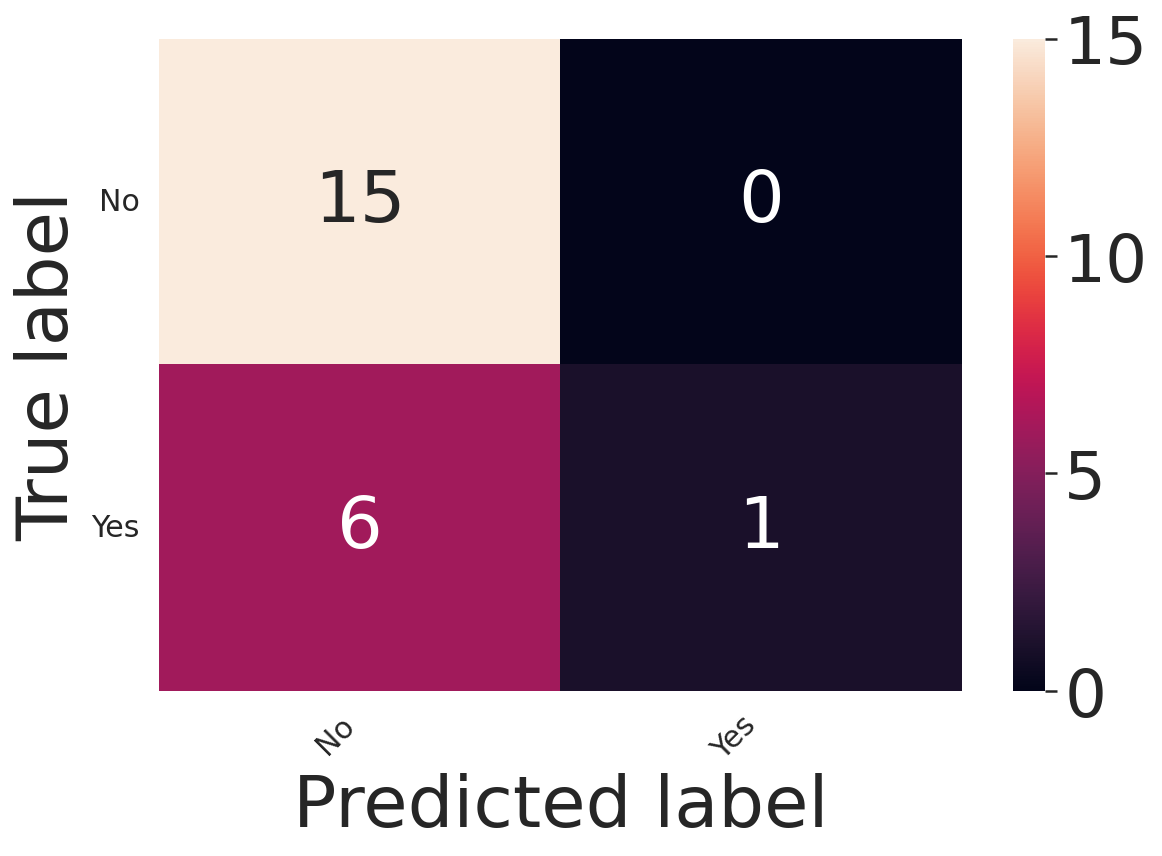

In [ ]:
nb_classes = 2
confusion_matrix = np.zeros((nb_classes, nb_classes))
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders_dict['val']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

sns.set(font_scale=3) # font size 2
plt.figure(figsize=(9, 6))

class_names = ['No', 'Yes']
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [ ]:
#Case-4
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=False) 

Epoch 0/14
----------
train Loss: 0.7690 Acc: 0.5625
val Loss: 0.7501 Acc: 0.6818

Epoch 1/14
----------
train Loss: 0.6433 Acc: 0.7083
val Loss: 0.5917 Acc: 0.7273

Epoch 2/14
----------
train Loss: 0.5563 Acc: 0.7500
val Loss: 0.5948 Acc: 0.6818

Epoch 3/14
----------
train Loss: 0.5595 Acc: 0.7083
val Loss: 0.6056 Acc: 0.6818

Epoch 4/14
----------
train Loss: 0.5330 Acc: 0.6667
val Loss: 0.7057 Acc: 0.5455

Epoch 5/14
----------
train Loss: 0.5116 Acc: 0.7500
val Loss: 0.7154 Acc: 0.6364

Epoch 6/14
----------
train Loss: 0.4215 Acc: 0.7917
val Loss: 0.6822 Acc: 0.5909

Epoch 7/14
----------
train Loss: 0.3702 Acc: 0.8750
val Loss: 0.6768 Acc: 0.5455

Epoch 8/14
----------
train Loss: 0.3114 Acc: 0.8542
val Loss: 0.7532 Acc: 0.6818

Epoch 9/14
----------
train Loss: 0.2889 Acc: 0.8958
val Loss: 0.7491 Acc: 0.5909

Epoch 10/14
----------
train Loss: 0.2854 Acc: 0.9167
val Loss: 0.7172 Acc: 0.5455

Epoch 11/14
----------
train Loss: 0.2747 Acc: 0.8750
val Loss: 0.6943 Acc: 0.7273

Ep

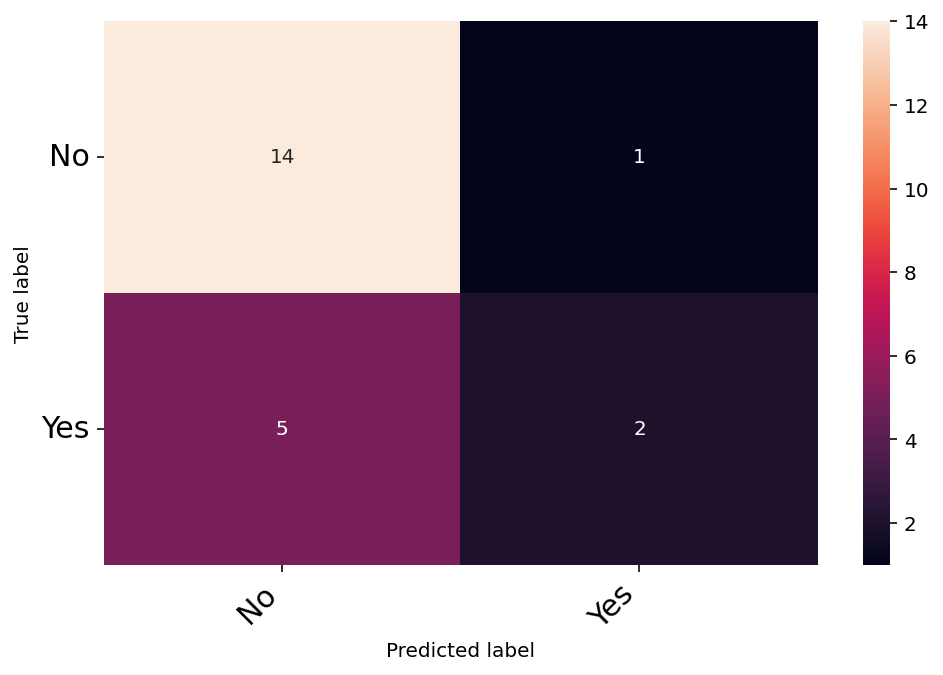

In [ ]:
nb_classes = 2
confusion_matrix = np.zeros((nb_classes, nb_classes))
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders_dict['val']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

plt.figure(figsize=(8,5))

class_names = ['No', 'Yes']
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [ ]:
#Case-3
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=False) 

Epoch 0/14
----------
train Loss: 0.6650 Acc: 0.6875
val Loss: 0.6744 Acc: 0.6818

Epoch 1/14
----------
train Loss: 0.6208 Acc: 0.6458
val Loss: 0.6279 Acc: 0.6818

Epoch 2/14
----------
train Loss: 0.5537 Acc: 0.7083
val Loss: 0.6190 Acc: 0.6818

Epoch 3/14
----------
train Loss: 0.5230 Acc: 0.7708
val Loss: 0.6198 Acc: 0.6818

Epoch 4/14
----------
train Loss: 0.5488 Acc: 0.7917
val Loss: 0.6189 Acc: 0.6818

Epoch 5/14
----------
train Loss: 0.4207 Acc: 0.8125
val Loss: 0.5949 Acc: 0.6818

Epoch 6/14
----------
train Loss: 0.4662 Acc: 0.7500
val Loss: 0.6083 Acc: 0.6818

Epoch 7/14
----------
train Loss: 0.3934 Acc: 0.8542
val Loss: 0.5741 Acc: 0.7727

Epoch 8/14
----------
train Loss: 0.3431 Acc: 0.8333
val Loss: 0.5808 Acc: 0.7273

Epoch 9/14
----------
train Loss: 0.3692 Acc: 0.8542
val Loss: 0.5774 Acc: 0.7727

Epoch 10/14
----------
train Loss: 0.2376 Acc: 0.9583
val Loss: 0.6119 Acc: 0.7273

Epoch 11/14
----------
train Loss: 0.2830 Acc: 0.8542
val Loss: 0.6694 Acc: 0.6818

Ep

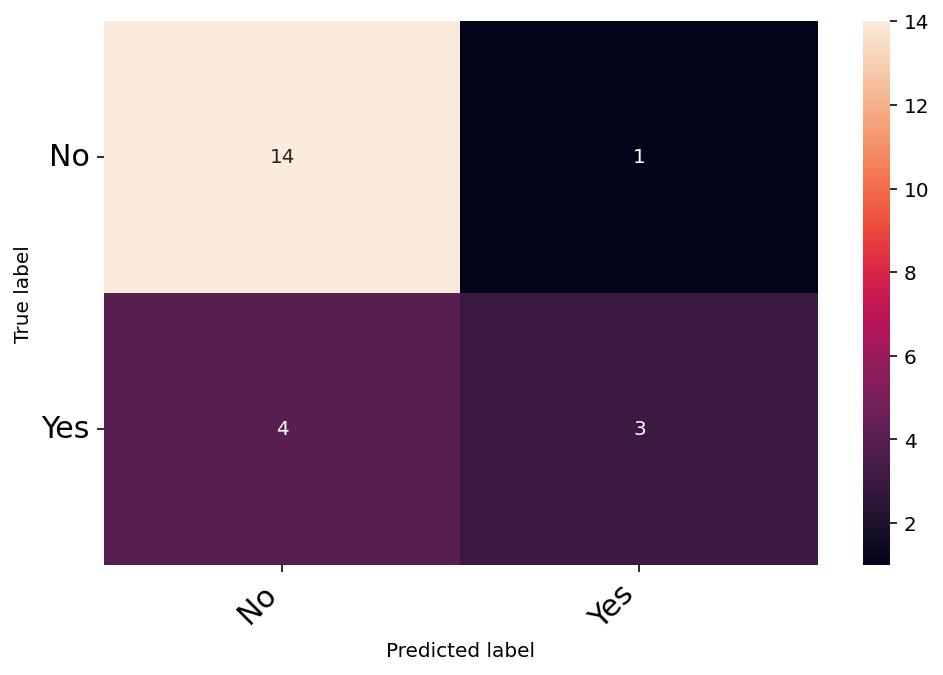

In [ ]:
nb_classes = 2
confusion_matrix = np.zeros((nb_classes, nb_classes))
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders_dict['val']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

plt.figure(figsize=(8,5))

class_names = ['No', 'Yes']
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [ ]:
#Case-2
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=False) 

Epoch 0/14
----------
train Loss: 0.6222 Acc: 0.6667
val Loss: 0.7543 Acc: 0.6818

Epoch 1/14
----------
train Loss: 0.6940 Acc: 0.7083
val Loss: 0.8209 Acc: 0.6818

Epoch 2/14
----------
train Loss: 0.4853 Acc: 0.7708
val Loss: 0.7657 Acc: 0.4545

Epoch 3/14
----------
train Loss: 0.4834 Acc: 0.7500
val Loss: 0.9704 Acc: 0.6818

Epoch 4/14
----------
train Loss: 0.3693 Acc: 0.8333
val Loss: 0.9699 Acc: 0.6818

Epoch 5/14
----------
train Loss: 0.3846 Acc: 0.7917
val Loss: 0.9706 Acc: 0.5909

Epoch 6/14
----------
train Loss: 0.2570 Acc: 0.8750
val Loss: 1.0144 Acc: 0.6364

Epoch 7/14
----------
train Loss: 0.3036 Acc: 0.8542
val Loss: 1.0683 Acc: 0.6364

Epoch 8/14
----------
train Loss: 0.2372 Acc: 0.8958
val Loss: 1.0590 Acc: 0.5000

Epoch 9/14
----------
train Loss: 0.1711 Acc: 0.9375
val Loss: 1.2433 Acc: 0.6364

Epoch 10/14
----------
train Loss: 0.3479 Acc: 0.8125
val Loss: 1.1898 Acc: 0.6364

Epoch 11/14
----------
train Loss: 0.2049 Acc: 0.8958
val Loss: 1.2275 Acc: 0.5909

Ep

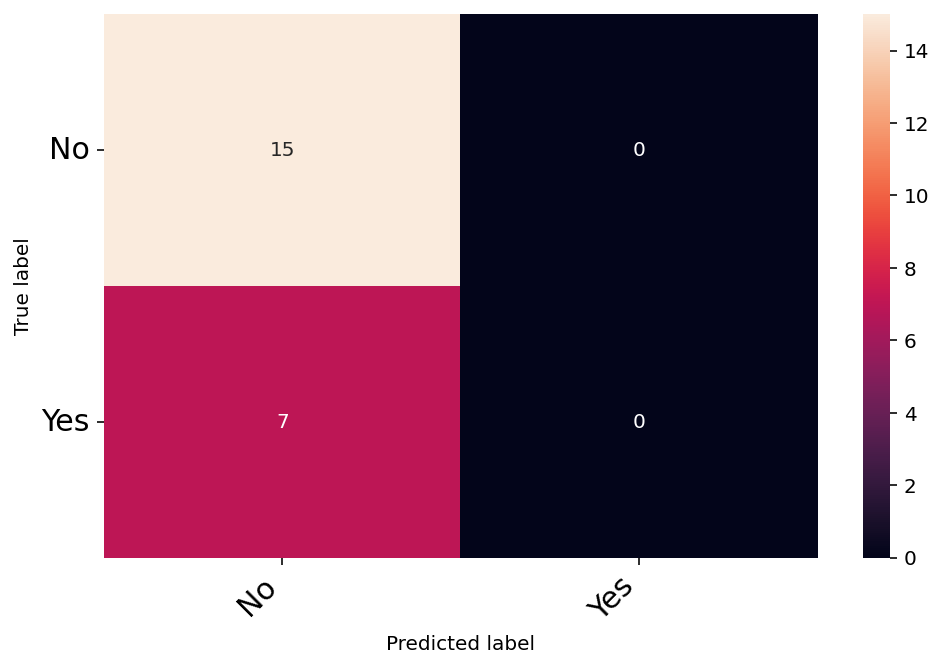

In [ ]:
nb_classes = 2
confusion_matrix = np.zeros((nb_classes, nb_classes))
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders_dict['val']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

plt.figure(figsize=(8,5))

class_names = ['No', 'Yes']
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [ ]:
# Case-1
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=False) 

Epoch 0/14
----------
train Loss: 0.6355 Acc: 0.6875
val Loss: 0.5990 Acc: 0.6818

Epoch 1/14
----------
train Loss: 0.6218 Acc: 0.7083
val Loss: 0.5576 Acc: 0.7273

Epoch 2/14
----------
train Loss: 0.5668 Acc: 0.7083
val Loss: 0.5612 Acc: 0.6818

Epoch 3/14
----------
train Loss: 0.5107 Acc: 0.7708
val Loss: 0.5851 Acc: 0.6818

Epoch 4/14
----------
train Loss: 0.4842 Acc: 0.7708
val Loss: 0.5855 Acc: 0.6818

Epoch 5/14
----------
train Loss: 0.3837 Acc: 0.8333
val Loss: 0.6389 Acc: 0.6818

Epoch 6/14
----------
train Loss: 0.4176 Acc: 0.8333
val Loss: 0.6441 Acc: 0.6364

Epoch 7/14
----------
train Loss: 0.4051 Acc: 0.8125
val Loss: 0.6344 Acc: 0.6818

Epoch 8/14
----------
train Loss: 0.3598 Acc: 0.8958
val Loss: 0.7846 Acc: 0.6818

Epoch 9/14
----------
train Loss: 0.4691 Acc: 0.7708
val Loss: 0.6409 Acc: 0.7273

Epoch 10/14
----------
train Loss: 0.4632 Acc: 0.8125
val Loss: 0.5800 Acc: 0.6818

Epoch 11/14
----------
train Loss: 0.2452 Acc: 0.8750
val Loss: 0.8461 Acc: 0.6818

Ep

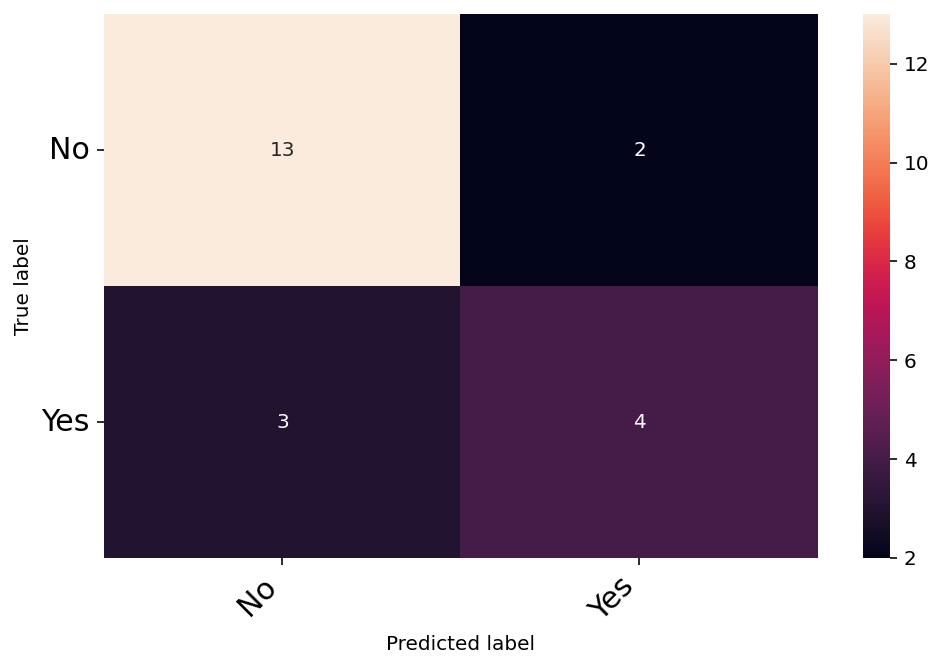

In [ ]:
nb_classes = 2
confusion_matrix = np.zeros((nb_classes, nb_classes))
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders_dict['val']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

plt.figure(figsize=(8,5))

class_names = ['No', 'Yes']
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [ ]:
confusion_matrix = torch.zeros(2, 2)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders_dict['val']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[13.,  2.],
        [ 3.,  4.]])


Epoch 0/14
----------


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


train Loss: 0.6847 Acc: 0.7083
val Loss: 0.6671 Acc: 0.6818

Epoch 1/14
----------
train Loss: 0.8004 Acc: 0.3542
val Loss: 0.6626 Acc: 0.6818

Epoch 2/14
----------
train Loss: 0.7971 Acc: 0.7083
val Loss: 0.7234 Acc: 0.6818

Epoch 3/14
----------
train Loss: 0.7481 Acc: 0.6458
val Loss: 0.6559 Acc: 0.6818

Epoch 4/14
----------
train Loss: 0.6586 Acc: 0.6458
val Loss: 0.6156 Acc: 0.6818

Epoch 5/14
----------
train Loss: 0.5927 Acc: 0.7083
val Loss: 0.6500 Acc: 0.6364

Epoch 6/14
----------
train Loss: 0.5779 Acc: 0.7083
val Loss: 0.6452 Acc: 0.6818

Epoch 7/14
----------
train Loss: 0.5814 Acc: 0.7083
val Loss: 0.6333 Acc: 0.6818

Epoch 8/14
----------
train Loss: 0.5681 Acc: 0.6875
val Loss: 0.6587 Acc: 0.6818

Epoch 9/14
----------
train Loss: 0.5733 Acc: 0.7292
val Loss: 0.7174 Acc: 0.6818

Epoch 10/14
----------
train Loss: 0.5569 Acc: 0.7292
val Loss: 0.6590 Acc: 0.5455

Epoch 11/14
----------
train Loss: 0.5825 Acc: 0.7083
val Loss: 0.7205 Acc: 0.5000

Epoch 12/14
----------
t

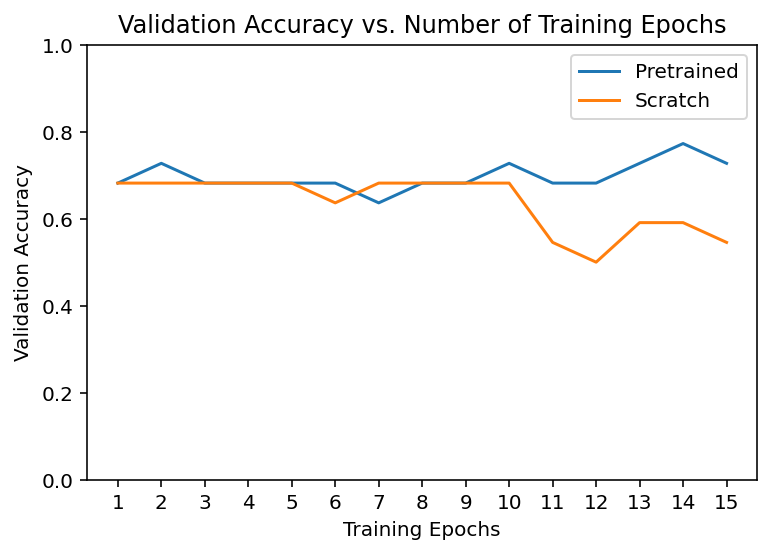

In [ ]:
# Initialize the non-pretrained version of the model used for this run
scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_,scratch_hist = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))

# Plot the training curves of validation accuracy vs. number
#  of training epochs for the transfer learning method and
#  the model trained from scratch
ohist = []
shist = []

ohist = [h.cpu().numpy() for h in hist]
shist = [h.cpu().numpy() for h in scratch_hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()